# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [164]:
import os
import zipfile
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
import math
import statistics
import math
import numpy as np
from scipy.stats import shapiro 
from scipy.stats import lognorm

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA

cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

Exploring data
- How many people have a normal ECG?
- How many people have an abnormal ECG?
- Is there any missing data?
- Are there outliers? -> nog bedenken wat we hier mee willen!


In [165]:
# split labels from data
x = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# normal / abnormal ECGs
total_abnormal_ECG = np.count_nonzero(y)  # current dataset has 146 nonzeros
total_normal_ECG = y.size -np.count_nonzero(y)  # current dataset has 681 zeros
percentage_abnormal = total_abnormal_ECG / (total_abnormal_ECG + total_normal_ECG)*100  # 17.65 %

# Missing data
x = x.replace(0, np.nan)  # make all zeros to NaN
nan_count = x.isna().sum().sum()  # count missing data -> 10500 in our dataset

# Outliers


Missing data
- Removing features if there is lot of data missing (replace all for a value)
- Removing samples (in this case patients) if there is a lot of data missing
- Imputation for generating data to fill us missing values -> median

Exploring
- Is the data normally distributed?

In [166]:
# Determine the amount of features
n_features = x.shape[1]
print(n_features, 'Number of features')

# Determine the amount of patients
n_patients = x.shape[0]
print(n_patients, 'Number of patients')

# Delete missing data when > --% of feature of sample is missing
x = x.dropna(axis='columns', how='all') # deletes a feature if all values of a column (so feature) are empty
x = x.dropna(axis='rows', how='all') # deletes a patient if all values of a row (so sample) are empty

# Missing data to median per feature
for column in x.columns:
    x[column].fillna(x[column].median(), inplace=True)

# Normally distributed
stat = []
p = []
for col in x.columns:
    if x[col].dtype == 'float64' or x[col].dtype == 'int64':
        s, pv = shapiro(x[col])
        stat.append(s)
        p.append(pv)
    else:
        stat.append(None)
        p.append(None)

# create a new dataframe to store the results
results = pd.DataFrame({'Column': x.columns, 'W': stat, 'p-value': p}) 
mean_p_value = results['p-value'].mean()  # p-value is really small. If p-value is bigger than 0.05, then data is normally distributed. SO its not
median_p_value = results['p-value'].median()  # p-value is really small. If p-value is bigger than 0.05, then data is normally distributed. SO its not

# Outliers: Tukey's fence 
k=1.5
fences=pd.DataFrame()
for col in x.columns:
    q1, q3 = np.percentile(x[col], [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - k*iqr
    upper_fence = q3 + k*iqr
    fences[col]=[lower_fence, upper_fence]
# print(fences)

9000 Number of features
827 Number of patients


C:\Users\ellem\AppData\Local\Temp\ipykernel_7444\294956819.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fences[col]=[lower_fence, upper_fence]
C:\Users\ellem\AppData\Local\Temp\ipykernel_7444\294956819.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fences[col]=[lower_fence, upper_fence]
C:\Users\ellem\AppData\Local\Temp\ipykernel_7444\294956819.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

Splitting data into training and test data
- Subset training and test based on ratios
- Stratification
- Cross-validation?




In [167]:
# Split data
X_train, X_test_DO_NOT_FIT, y_train, y_test_DO_NOT_FIT = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
y_train_ab = y_train==1  # waarom maken we hier bools van? ipv 1 en 0 hebben we nu true en false
# X_test_DO_NOT_FIT and y_test_DO_NOT_FIT SHOULD NOT BE USED FOR FITTING

# Scale the data to be normal
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test_scaled_DO_NOT_FIT = scaler.transform(X_test_DO_NOT_FIT)

# Cross-validation
# cv_20fold = model_selection.StratifiedKFold(n_splits=10) --> uit college 1.2_generalization.ipyb

# Loop over the folds
#for validation_index, test_index in cv_20fold.split(X2, y2):
    # Split the data properly
#    X_validation = X2[validation_index]
#    y_validation = y2[validation_index]
    
#    X_test = X2[test_index]
#    y_test = y2[test_index]


Feature selection:
- Remove features with zero variance

In [168]:
sel_vt = VarianceThreshold(threshold=0.0)
X_vt = sel_vt.fit_transform(X_train, y_train)
print(X_vt.shape)

(620, 9000)


PCA
- How many principal components? (n=2/3) --> to make plots visual
- Scree plot to determine amount of features to use?


In [169]:
# Reduce the number of features with PCA.
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_features = min(n_samples, n_features)

pca = PCA(n_components=n_features)            
X_train = pca.fit_transform(X_train)

print(n_samples)
print(n_features)
print(pca.n_components_)

620
620
620


- Univariate

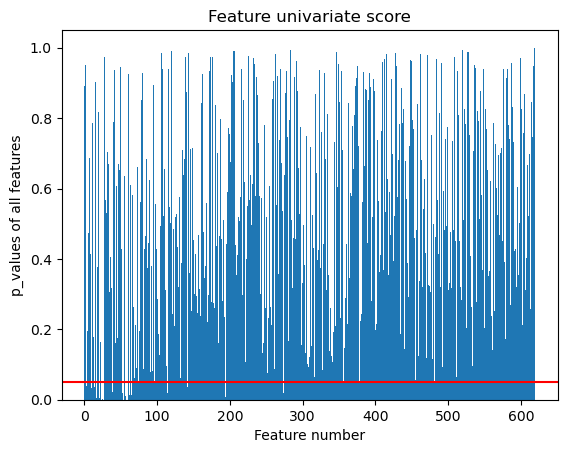

In [170]:
# selectKbest features 
sel_kb = SelectKBest(f_classif, k='all')        # we trainen selector wel met 620 best en daarna pakken we pas de p_waarden --> kan dat wel?
sel_kb.fit(X_train, y_train)                         # is het dan, omdat we alleen 'fit' doen en niet 'fit_transform' dat de k niet uitmaakt, omdat we X_train niet transformen, maar de 'empirical variances of X' nemen
p_values = sel_kb.pvalues_

# plot p-values of all features
X_indices = np.arange(X_train.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, p_values, width=1)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel('p_values of all features')
plt.show()


In [171]:
# select features with p_value =< 0.05
features_selected = np.array(np.where(p_values <= 0.05))
print(features_selected.shape)

# select significant features in training set
X_train = X_train[:,features_selected[0,:]]
print(X_train.shape)

(1, 31)
(620, 31)


Function to make 2D-colorplot

In [172]:
# def colorplot(clf, ax, x, y, h=100, precomputer=None):
#     '''
#     Overlay the decision areas as colors in an axes.
    
#     Input:
#         clf: trained classifier
#         ax: axis to overlay color mesh on
#         x: feature on x-axis
#         y: feature on y-axis
#         h(optional): steps in the mesh
#     '''
#     # Create a meshgrid the size of the axis
#     xstep = (x.max() - x.min() ) / 20.0
#     ystep = (y.max() - y.min() ) / 20.0
#     x_min, x_max = x.min() - xstep, x.max() + xstep
#     y_min, y_max = y.min() - ystep, y.max() + ystep
#     h = max((x_max - x_min, y_max - y_min))/h
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                          np.arange(y_min, y_max, h))

#     features = np.c_[xx.ravel(), yy.ravel()]
#     if precomputer is not None:
#         if type(precomputer) is RBFSampler:
#             features = precomputer.transform(features)
#         elif precomputer is rbf_kernel:
#             features = rbf_kernel(features, X)
            
#     # Plot the decision boundary. For that, we will assign a color to each
#     # point in the mesh [x_min, x_max]x[y_min, y_max].
#     if hasattr(clf, "decision_function"):
#         Z = clf.decision_function(features)
#     else:
#         Z = clf.predict_proba(features)
#     if len(Z.shape) > 1:
#         Z = Z[:, 1]

Trying out some basic classifiers

In [173]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [174]:
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111)
# ax.set_title("Two informative features, one cluster per class",
#              fontsize='small')
# ax.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train,
#            s=25, edgecolor='k', cmap=plt.cm.Paired)
clf = LinearDiscriminantAnalysis()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
# colorplot(clf, ax, X_train[:, 0], X_train[:, 1])
print("Number of mislabeled points out of a total %d points : %d" % (X_train.shape[0], (y_train != y_pred).sum()))


y_pred=clf.predict(X_train)

if hasattr(clf, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
    y_score = clf.predict_proba(X_train)[:, 1]
else:
     y_score = y_pred

auc = metrics.roc_auc_score(y_train, y_score)
accuracy=metrics.accuracy_score(y_train, y_pred)
F1=metrics.f1_score(y_train, y_pred)
precision=metrics.precision_score(y_train, y_pred)
recall=metrics.recall_score(y_train, y_pred)
# accuracy, AUC, f1score, precision, recall
print(type(clf))
print('Acc:' +str(accuracy))
print('AUC:' +str(auc))
print('F1:' +str(F1))
print('precision:' +str(precision))
print('recall:' +str(recall))


Number of mislabeled points out of a total 620 points : 62
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Acc:0.9
AUC:0.9200344709958886
F1:0.6395348837209303
precision:0.873015873015873
recall:0.5045871559633027
